In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv('recipes_nutrients_info.csv')
df.rename(columns={'Unnamed: 0': 'title'}, inplace=True)
df.head()

,title,Fat,Fibers,Sugar,Carbs,Kcal,Protein,Caloric Density,Protein_Kcal Ratio,Kcal Classification,Macronutrients Classification,Diet Suitability,Nutritious
0,German Sweet Potato Salad,3.314384,4.159106,3.581144,12.888457,105.552780,6.301326,4.690366,0.059698,Moderate Calorie,Balanced,High Fiber,True
1,Black Bean Chili,31.277811,0.542302,1.081013,2.719898,296.066690,0.942940,8.473417,0.003185,Moderate Calorie,High Fat,Low Carb,False
2,Madeira Duck With Mixed Wild Mushrooms,1.378887,5.561102,5.445622,5.632484,148.269650,18.291302,5.859841,0.123365,Moderate Calorie,High Protein,"Low Carb, Low Fat",False
3,Grand Salmon Spread,3.626564,1.333046,2.526489,5.778238,82.906849,7.470238,4.912987,0.090104,Low Calorie,Balanced,"Low Carb, Low Fat",True
4,Bean And Pasta Salad Recipe,44.435216,3.993024,6.712235,13.147701,471.586120,6.069408,7.408781,0.012870,High Calorie,High Fat,High Fiber,False


In [8]:
#prepare data for finetunning 
recipes_df = pd.read_csv('sampled_1M.csv')
recipes_df.head()

,Unnamed: 0,title,ingredients,directions,NER,ingredients_list
0,0,German Sweet Potato Salad,"[""2 medium sweet potatoes"", ""1 1/2 cups caulif...","[""Prick the sweet potatoes with a fork, and mi...","[""sweet potatoes"", ""cauliflower florets"", ""whi...","['sweet potatoes', 'cauliflower florets', 'whi..."
1,1,Black Bean Chili,"[""2 cup black beans, soak over nite"", ""4 cup w...","[""recipe was based on recipe from cookbook 'In...","[""black beans"", ""water"", ""bell pepper"", ""onion...","['black beans', 'water', 'bell pepper', 'onion..."
2,2,Madeira Duck With Mixed Wild Mushrooms,"[""4 boneless duck breasts, skinned"", ""3 garlic...","[""Slice the duck breasts and place in a shallo...","[""duck breasts"", ""garlic"", ""chicken"", ""madeira...","['duck breasts', 'garlic', 'chicken', 'madeira..."
3,3,Grand Salmon Spread,"[""1 pkg. (3 oz.) PHILADELPHIA Cream Cheese, so...","[""Mix cream cheese, juice and horseradish unti...","[""PHILADELPHIA Cream Cheese"", ""lemon juice"", ""...","['PHILADELPHIA Cream Cheese', 'lemon juice', '..."
4,4,Bean And Pasta Salad Recipe,"[""4 ounce rotini (corkscrew) pasta"", ""15 ounce...","[""1."", ""Cook pasta till al dente in plenty of ...","[""rotini"", ""black beans"", ""red pepper"", ""red o...","['rotini', 'black beans', 'red pepper', 'red o..."


In [26]:
# merge the two dataframes by title
merged_df = pd.merge(recipes_df, df[['title', 'Nutritious']], on='title', how='inner')
merged_df.dropna(inplace=True)
merged_df.drop_duplicates()
merged_df.drop(columns=['ingredients_list', 'NER', 'Unnamed: 0'], inplace=True)
merged_df.reset_index(drop=True, inplace=True)
print(merged_df.shape)
merged_df.head()

(201091, 4)


,title,ingredients,directions,Nutritious
0,German Sweet Potato Salad,"[""2 medium sweet potatoes"", ""1 1/2 cups caulif...","[""Prick the sweet potatoes with a fork, and mi...",True
1,Black Bean Chili,"[""2 cup black beans, soak over nite"", ""4 cup w...","[""recipe was based on recipe from cookbook 'In...",False
2,Madeira Duck With Mixed Wild Mushrooms,"[""4 boneless duck breasts, skinned"", ""3 garlic...","[""Slice the duck breasts and place in a shallo...",False
3,Grand Salmon Spread,"[""1 pkg. (3 oz.) PHILADELPHIA Cream Cheese, so...","[""Mix cream cheese, juice and horseradish unti...",True
4,Bean And Pasta Salad Recipe,"[""4 ounce rotini (corkscrew) pasta"", ""15 ounce...","[""1."", ""Cook pasta till al dente in plenty of ...",False


In [27]:
#merge the title, ingredients and directions into one column
#Mark the title, ingredients and directions with a special token
merged_df['title'] = merged_df['title'].apply(lambda x: 'title: ' + x)
merged_df['ingredients'] = merged_df['ingredients'].apply(lambda x: 'ingredients: ' + x)
merged_df['directions'] = merged_df['directions'].apply(lambda x: 'directions: ' + x)
merged_df['text'] = merged_df['title'] + ' ' + merged_df['ingredients'] + ' ' + merged_df['directions']
merged_df.drop(columns=['title', 'ingredients', 'directions'], inplace=True)
merged_df.head()

,Nutritious,text
0,True,title: German Sweet Potato Salad ingredients: ...
1,False,"title: Black Bean Chili ingredients: [""2 cup b..."
2,False,title: Madeira Duck With Mixed Wild Mushrooms ...
3,True,"title: Grand Salmon Spread ingredients: [""1 pk..."
4,False,title: Bean And Pasta Salad Recipe ingredients...


Fine tunning BERT



/var/folders/1y/r5jmwn4n0r599hsjjrhbwstm0000gn/T/ipykernel_3150/3958619569.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged_df['text_length'])


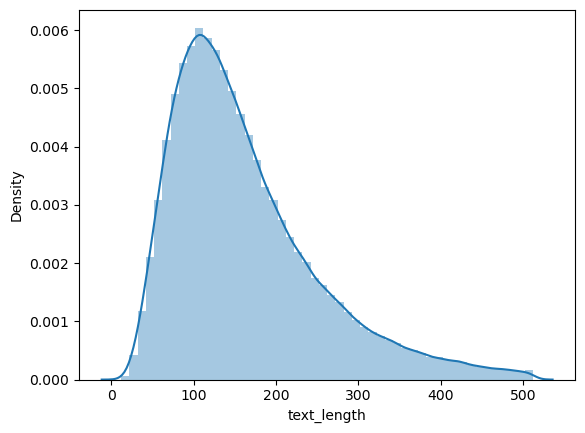

In [28]:
#check the distribution of the length of the text

merged_df['text_length'] = merged_df['text'].apply(lambda x: len(x.split()))
merged_df = merged_df[merged_df['text_length'] <= 512]
sns.distplot(merged_df['text_length'])  
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["recipe_text"], df["Nutritious"], test_size=0.2, random_state=42
)

# Convert to list format
train_texts, test_texts = train_texts.tolist(), test_texts.tolist()
train_labels, test_labels = train_labels.tolist(), test_labels.tolist()


In [30]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the fine-tuned model and tokenizer
model_name = "model"  # Replace with the actual path
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)



In [46]:

print(test_text)
model_inputs = tokenizer(test_text, return_tensors="pt")
model_outputs = model(**model_inputs)

title: Peanut Butter Graham Squares With Dark Chocolate Drizzle ingredients: ["4 -5 whole graham crackers", "34 cup graham cracker crumbs", "8 tablespoons margarine, softened", "1 14 cups confectioners' sugar", "6 tablespoons reduced-calorie peanut butter", "12 teaspoon vanilla", "14 teaspoon salt", "melted dark chocolate, to drizzle"] directions: ["Arrange whole graham crackers in the bottom of an 8x8\" square baking dish.", "In a medium mixing bowl, beat together graham cracker crumbs, butter, sugar, peanut butter, vanilla and salt until smooth.", "Scoop this mixture into the baking dish and gently spread over the graham crackers.", "Cover and place in the refrigerator for at least 1 hour.", "Cut into squares and drizzle with melted dark chocolate."]


In [90]:
import torch
def predict_nutritious(text):
    model_inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    model_outputs = model(**model_inputs)
    logits = model_outputs.logits
    score = logits[0][0].item()
    if score > 0.414:
        return (1, score)
    else:
        return (0, score)

In [80]:
text = merged_df['text'][3]
result = predict_nutritious(text)
result

1

In [74]:
result[0][0].item()

0.0929337739944458

In [81]:
#predict the nutritious of the recipes
test_df = pd.read_csv('full_dataset.csv')


In [84]:
test_sample = test_df[:100]
test_sample['title'] = test_sample['title'].apply(lambda x: 'title: ' + x)
test_sample['ingredients'] = test_sample['ingredients'].apply(lambda x: 'ingredients: ' + x)
test_sample['directions'] = test_sample['directions'].apply(lambda x: 'directions: ' + x)
test_sample['text'] = test_sample['title'] + ' ' + test_sample['ingredients'] + ' ' + test_sample['directions']
test_sample.drop(columns=['title', 'ingredients', 'directions', 'link', 'source', 'NER', 'Unnamed: 0'], inplace=True)
test_sample.head()

/var/folders/1y/r5jmwn4n0r599hsjjrhbwstm0000gn/T/ipykernel_3150/3704905507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample['title'] = test_sample['title'].apply(lambda x: 'title: ' + x)
/var/folders/1y/r5jmwn4n0r599hsjjrhbwstm0000gn/T/ipykernel_3150/3704905507.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample['ingredients'] = test_sample['ingredients'].apply(lambda x: 'ingredients: ' + x)
/var/folders/1y/r5jmwn4n0r599hsjjrhbwstm0000gn/T/ipykernel_3150/3704905507.py:4: SettingWi

,text
0,"title: No-Bake Nut Cookies ingredients: [""1 c...."
1,"title: Jewell Ball'S Chicken ingredients: [""1 ..."
2,"title: Creamy Corn ingredients: [""2 (16 oz.) p..."
3,"title: Chicken Funny ingredients: [""1 large wh..."
4,"title: Reeses Cups(Candy) ingredients: [""1 c..."


In [85]:
test_sample['Nutritious'] = test_sample['text'].apply(lambda x: predict_nutritious(x))

/var/folders/1y/r5jmwn4n0r599hsjjrhbwstm0000gn/T/ipykernel_3150/2947068236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample['Nutritious'] = test_sample['text'].apply(lambda x: predict_nutritious(x))


In [91]:
text = 'title: Oat meal pancakes with oat milk ingredients: 1 cup oats, 2 eggs, 1 cup oat milk, a pinch of cinamon, 2 apples directions: Mix the ingredients together and blend until smooth and then cook on a pan using just a bit of vegetable oil'
predict_nutritious(text)

(1, 0.46827346086502075)